# TODOS (Design):

1. Create the list of functions
2. Generate the Clean and Dirty datasets
3. Train on Clean and Dirty datasets
4. Repeat (3) for different activation functions (Tanh, Sigmoid, ReLU, PReLU, etc...)
5. For each function, create a figure depicting each model's predictions vs the real value
6. Compare the figures from (5) to see which activation functions performed better

# Importing Packages

In [23]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler

# Defining Configuration

In [24]:
config = {
    'max_epochs': 20,
    'batch_size': 64,
    'lr': 0.001,
    'weight_decay': 1e-10,
    'num_cols': 10,
}

# Generate the Clean and Dirty Datasets

### Create the list of functions

In [25]:
class DatasetFactory:
    def __init__(self, domain, dirty_frac=0.1, cols=config['num_cols']):
        # TODO: Create the list of functions
        C = 2 * np.random.random_sample(11) - 1  # constants
        self.funcs = [
            lambda x : C[0] * math.sin(x),
            lambda x : C[1] * math.cos(x), 
            lambda x: C[2] * x + C[3],
            lambda x: C[4] * x**2 + C[5] * x + C[6],
            lambda x: C[7] * x**3 + C[8] * x**2 + C[9] * x + C[10],
            # lambda x: 0 if x == 0 else math.sin(1/x),
            # lambda x: math.e ** x,
        ]
        if cols < len(self.funcs):
            self.funcs = self.funcs[0:cols]
        while cols > len(self.funcs):
            self.funcs.append(random.choice(self.funcs))
            # f, g = random.choices(self.funcs, k=2)
            # rand_operation = random.randint(0, 1)
            # if (rand_operation == 0):
            #     self.funcs.append(lambda x: f(x) * g(x))
            # elif (rand_operation == 1): 
            #     self.funcs.append(lambda x: f(g(x)))
            # else:
            #     continue

        
        columns = []
        for j in range(cols):
            np.random.shuffle(domain)
            columns.append(domain.tolist())

        self.X_trans_clean = []
        self.X_clean = []
        for i in range(len(columns[0])):
            row = []
            row_trans = []
            for j in range(len(columns)):
                row.append(columns[j][i])
                # row_trans.append(columns[j][i])
                # f = self.funcs[j % len(self.funcs)]
                # row_trans.append(f(columns[j][i]))
                # print(columns[j][i])
                row_trans.append(self.funcs[j](columns[j][i]))
            self.X_clean.append(row)
            self.X_trans_clean.append(row_trans)
            
        # Transforming lists into arrays and standardizing
        self.X_clean = np.array(self.X_clean, dtype=float)
        self.X_trans_clean = np.array(self.X_trans_clean, dtype=float)
        self.X_clean = StandardScaler().fit_transform(self.X_clean)
        self.X_trans_clean = StandardScaler().fit_transform(self.X_trans_clean)
        self.y_clean = np.mean(self.X_trans_clean, axis=1)

        # Create the dirty data by adding Gaussian noise to a portion of the clean_data
        noise = np.random.normal(loc=0, scale=0.5, size=(math.floor(dirty_frac * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        no_noise = np.zeros(shape=(math.ceil((1 - dirty_frac) * self.X_clean.shape[0]), self.X_clean.shape[1] + 1))
        self.offset = np.concatenate((noise, no_noise))
        np.random.shuffle(self.offset)
        self.X_dirty = self.X_clean + self.offset[:, 0:self.X_clean.shape[1]]
        self.X_trans_dirty = self.X_trans_clean + self.offset[:, 0:self.X_clean.shape[1]]
        self.y_dirty = self.y_clean + self.offset[:, self.X_clean.shape[1]]

    def get_clean(self):
        return self.X_clean, self.y_clean
    
    def get_dirty(self):
        return self.X_dirty, self.y_dirty
    
    def get_trans(self):
        return self.X_trans_clean, self.X_trans_dirty
    
    def get_offset(self):
        return self.offset
    
    def get_funcs(self):
        return self.funcs

In [26]:
domain = np.arange(-875, 875, 0.25, dtype=float)
dataFactory = DatasetFactory(domain.copy())
X_clean, y_clean = dataFactory.get_clean()
print(X_clean.shape, y_clean.shape)
X_dirty, y_dirty = dataFactory.get_dirty()
X_trans_clean, X_trans_dirty = dataFactory.get_trans()

offset = dataFactory.get_offset()

(7000, 10) (7000,)


In [27]:
def display_function(domain, offset, f_i, title=''):
    func = dataFactory.get_funcs()[f_i]
    y_clean = np.apply_along_axis(func, 0, domain)
    y_clean = (y_clean - y_clean.mean()) / y_clean.std()
    domain = (domain - domain.mean()) / domain.std()
    y_dirty = y_clean + offset[:, f_i]
    figure(figsize=(6, 4))
    plt.plot(domain, y_dirty, c='tab:cyan', label='dirty')
    plt.plot(domain, y_clean, c='tab:red', label='clean')
    plt.ylim(min(np.min(y_clean), np.min(y_dirty)), max(np.max(y_clean), np.max(y_dirty)))
    plt.xlabel('domain')
    plt.ylabel('target')
    plt.title(title)
    plt.legend()
    plt.show()

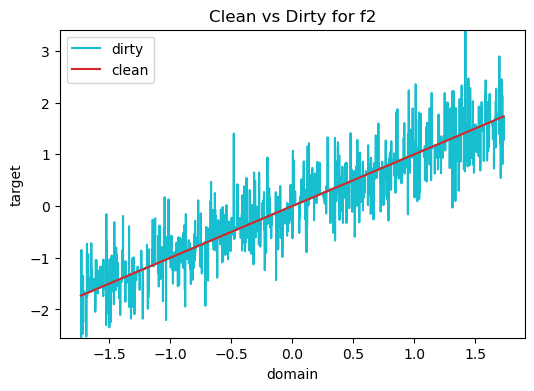

In [28]:
display_function(domain.copy(), offset, 2, 'Clean vs Dirty for f2')

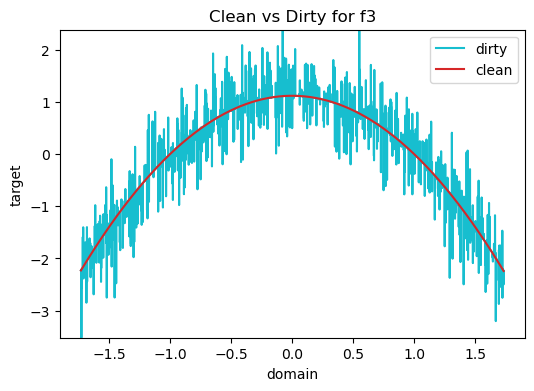

In [29]:
display_function(domain.copy(), offset, 3, 'Clean vs Dirty for f3')

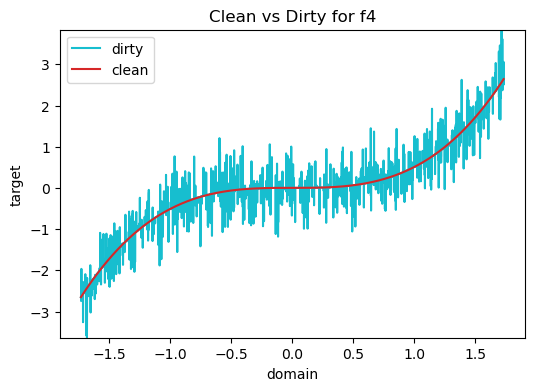

In [30]:
display_function(domain.copy(), offset, 4, 'Clean vs Dirty for f4')  

# Data Preprocessing

### Splitting into train and val

In [31]:
from sklearn.model_selection import train_test_split

X_train_clean, X_val, y_train_clean, y_val = train_test_split(X_clean, y_clean, test_size=2/7)
X_train_dirty, X_val_dirty, y_train_dirty, y_val_dirty = train_test_split(X_dirty, y_dirty, test_size=2/7)

### Creating Dataset

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader

In [33]:
class CustomDataset(Dataset):
    def __init__(self, X, y, mode):
        super(CustomDataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        
        self.dim = self.X.shape[0]
        print('Finished reading the {} set of Dataset ({} samples found, each dim = {})'.format(mode, len(self.X), self.dim))
        print(f"\tX.shape, X.dtype = {self.X.shape}, {self.X.dtype}")
        print(f"\ty.shape, y.dtype = {self.y.shape}, {self.y.dtype}")


    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [34]:
trainset_clean = CustomDataset(X_train_clean, y_train_clean, mode='train')
trainset_dirty = CustomDataset(X_train_dirty, y_train_dirty, mode='train')
valset = CustomDataset(X_val, y_val, mode='val')

Finished reading the train set of Dataset (5000 samples found, each dim = 5000)
	X.shape, X.dtype = torch.Size([5000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([5000, 1]), torch.float32
Finished reading the train set of Dataset (5000 samples found, each dim = 5000)
	X.shape, X.dtype = torch.Size([5000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([5000, 1]), torch.float32
Finished reading the val set of Dataset (2000 samples found, each dim = 2000)
	X.shape, X.dtype = torch.Size([2000, 10]), torch.float32
	y.shape, y.dtype = torch.Size([2000, 1]), torch.float32


### Creating Dataloader

In [35]:
train_loader_clean = DataLoader(trainset_clean, batch_size=config['batch_size'], shuffle=True)
train_loader_dirty = DataLoader(trainset_dirty, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

# Defining the Model

In [36]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cuda')

In [37]:
# TODO: Tune this model architecture
class Net(nn.Module):
    def __init__(self, activation_function, d_in=config['num_cols'], d_out=1):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128),
            nn.BatchNorm1d(128),
            activation_function(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            activation_function(),
            nn.Linear(64, d_out),
        )

        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

# Training

In [38]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from copy import deepcopy

# Testing
from sklearn.metrics import accuracy_score

In [39]:
def train(model, train_loader, val_loader, valset, optimizer=None):
    best_val_loss = 10000
    best_val_model = None
    loss_record = {'train': [], 'val': []}
    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    for epoch in range(config['max_epochs']):
        running_loss = 0.0
        running_size = 0
        # this shows a progress bar during training, which is valuable due to how long it takes to train
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = model.cal_loss(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_size += data.size(0)
            loss_record['train'].append(running_loss/running_size)
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                out = model(data.to(device)).cpu()
                val_loss += model.cal_loss(out, target).item()

        # this fixes the problem where val_set is off by one during plotting
        loss_record['val'].append(val_loss/len(valset))
        # Just print out the validation accuracy because it doesn't get updated repeatedly like how training accuracy does
        if val_loss/len(valset) < best_val_loss:
            best_val_loss = val_loss / len(valset)
            best_val_model = deepcopy(model.state_dict())
            print("Epoch {0:>2}: train loss={1:<10f} | val loss={2:<10f}".format(epoch+1, running_loss/running_size, val_loss/len(valset)))
    print('Finished Training')
    return loss_record, best_val_model

In [40]:
relu_loss_record_clean, relu_best_model_clean = train(Net(nn.ReLU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.000981   | val loss=0.000704  
Epoch  2: train loss=0.000690   | val loss=0.000666  
Epoch  3: train loss=0.000646   | val loss=0.000628  
Epoch  4: train loss=0.000585   | val loss=0.000593  
Epoch  7: train loss=0.000569   | val loss=0.000577  
Epoch  9: train loss=0.000522   | val loss=0.000577  
Epoch 14: train loss=0.000517   | val loss=0.000573  
Finished Training


In [41]:
relu_loss_record_dirty, relu_best_model_dirty = train(Net(nn.ReLU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001580   | val loss=0.000726  
Epoch  2: train loss=0.001172   | val loss=0.000695  
Epoch  3: train loss=0.001108   | val loss=0.000624  
Epoch  5: train loss=0.001057   | val loss=0.000604  
Epoch  6: train loss=0.001006   | val loss=0.000576  
Epoch  8: train loss=0.000984   | val loss=0.000566  
Epoch 10: train loss=0.000979   | val loss=0.000557  
Epoch 13: train loss=0.000921   | val loss=0.000544  
Epoch 19: train loss=0.000893   | val loss=0.000525  
Finished Training


In [42]:
lrelu_loss_record_clean, lrelu_best_model_clean = train(Net(nn.LeakyReLU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001038   | val loss=0.000746  
Epoch  2: train loss=0.000693   | val loss=0.000656  
Epoch  4: train loss=0.000626   | val loss=0.000629  
Epoch  5: train loss=0.000607   | val loss=0.000616  
Epoch  6: train loss=0.000579   | val loss=0.000604  
Epoch  7: train loss=0.000561   | val loss=0.000586  
Epoch  9: train loss=0.000560   | val loss=0.000585  
Epoch 13: train loss=0.000526   | val loss=0.000578  
Finished Training


In [43]:
lrelu_loss_record_dirty, lrelu_best_model_dirty = train(Net(nn.LeakyReLU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001634   | val loss=0.000718  
Epoch  3: train loss=0.001074   | val loss=0.000601  
Epoch  5: train loss=0.001015   | val loss=0.000571  
Epoch  6: train loss=0.000991   | val loss=0.000556  
Epoch  8: train loss=0.000953   | val loss=0.000556  
Epoch 10: train loss=0.000943   | val loss=0.000541  
Epoch 18: train loss=0.000915   | val loss=0.000535  
Epoch 19: train loss=0.000894   | val loss=0.000524  
Finished Training


In [44]:
prelu_loss_record_clean, prelu_best_model_clean = train(Net(nn.PReLU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001096   | val loss=0.000718  
Epoch  2: train loss=0.000722   | val loss=0.000651  
Epoch  3: train loss=0.000639   | val loss=0.000645  
Epoch  4: train loss=0.000633   | val loss=0.000611  
Epoch  7: train loss=0.000622   | val loss=0.000584  
Epoch  8: train loss=0.000588   | val loss=0.000582  
Epoch  9: train loss=0.000550   | val loss=0.000576  
Epoch 15: train loss=0.000550   | val loss=0.000570  
Finished Training


In [45]:
prelu_loss_record_dirty, prelu_best_model_dirty = train(Net(nn.PReLU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001570   | val loss=0.000705  
Epoch  2: train loss=0.001194   | val loss=0.000657  
Epoch  3: train loss=0.001142   | val loss=0.000608  
Epoch  6: train loss=0.001069   | val loss=0.000597  
Epoch  7: train loss=0.001058   | val loss=0.000567  
Epoch  9: train loss=0.001011   | val loss=0.000559  
Epoch 11: train loss=0.000980   | val loss=0.000547  
Epoch 12: train loss=0.000957   | val loss=0.000542  
Epoch 13: train loss=0.000955   | val loss=0.000538  
Epoch 16: train loss=0.000947   | val loss=0.000530  
Finished Training


In [46]:
elu_loss_record_clean, elu_best_model_clean = train(Net(nn.ELU).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001155   | val loss=0.000796  
Epoch  2: train loss=0.000737   | val loss=0.000618  
Epoch  3: train loss=0.000663   | val loss=0.000607  
Epoch  6: train loss=0.000616   | val loss=0.000567  
Epoch  9: train loss=0.000609   | val loss=0.000552  
Epoch 18: train loss=0.000572   | val loss=0.000551  
Epoch 20: train loss=0.000565   | val loss=0.000546  
Finished Training


In [47]:
elu_loss_record_dirty, elu_best_model_dirty = train(Net(nn.ELU).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001865   | val loss=0.000735  
Epoch  2: train loss=0.001230   | val loss=0.000672  
Epoch  4: train loss=0.001138   | val loss=0.000666  
Epoch  5: train loss=0.001107   | val loss=0.000662  
Epoch  6: train loss=0.001102   | val loss=0.000603  
Epoch  7: train loss=0.001092   | val loss=0.000603  
Epoch  8: train loss=0.001117   | val loss=0.000587  
Epoch 14: train loss=0.001038   | val loss=0.000571  
Epoch 16: train loss=0.001065   | val loss=0.000571  
Finished Training


In [48]:
softsign_loss_record_clean, softsign_best_model_clean = train(Net(nn.Softsign).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001230   | val loss=0.001103  
Epoch  2: train loss=0.001020   | val loss=0.001098  
Epoch  3: train loss=0.000986   | val loss=0.001087  
Epoch  4: train loss=0.000950   | val loss=0.001029  
Epoch  6: train loss=0.000900   | val loss=0.000995  
Epoch  7: train loss=0.000858   | val loss=0.000963  
Epoch  9: train loss=0.000772   | val loss=0.000864  
Epoch 10: train loss=0.000700   | val loss=0.000819  
Epoch 11: train loss=0.000681   | val loss=0.000735  
Epoch 12: train loss=0.000634   | val loss=0.000728  
Epoch 14: train loss=0.000596   | val loss=0.000699  
Epoch 15: train loss=0.000581   | val loss=0.000670  
Epoch 17: train loss=0.000567   | val loss=0.000649  
Epoch 19: train loss=0.000551   | val loss=0.000642  
Epoch 20: train loss=0.000532   | val loss=0.000642  
Finished Training


In [49]:
softsign_loss_record_dirty, softsign_best_model_dirty = train(Net(nn.Softsign).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001610   | val loss=0.001084  
Epoch  2: train loss=0.001443   | val loss=0.001024  
Epoch  3: train loss=0.001395   | val loss=0.001010  
Epoch  5: train loss=0.001365   | val loss=0.000985  
Epoch  6: train loss=0.001331   | val loss=0.000977  
Epoch  7: train loss=0.001288   | val loss=0.000929  
Epoch  8: train loss=0.001257   | val loss=0.000889  
Epoch  9: train loss=0.001223   | val loss=0.000864  
Epoch 10: train loss=0.001187   | val loss=0.000836  
Epoch 11: train loss=0.001127   | val loss=0.000787  
Epoch 12: train loss=0.001107   | val loss=0.000745  
Epoch 13: train loss=0.001079   | val loss=0.000745  
Epoch 14: train loss=0.001075   | val loss=0.000719  
Epoch 15: train loss=0.001022   | val loss=0.000709  
Epoch 16: train loss=0.000997   | val loss=0.000683  
Epoch 18: train loss=0.001028   | val loss=0.000614  
Finished Training


In [50]:
sigmoid_loss_record_clean, sigmoid_best_model_clean = train(Net(nn.Sigmoid).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001077   | val loss=0.001104  
Epoch  2: train loss=0.001004   | val loss=0.001014  
Epoch  4: train loss=0.001017   | val loss=0.001006  
Epoch  5: train loss=0.000983   | val loss=0.000993  
Epoch  6: train loss=0.000977   | val loss=0.000986  
Epoch  8: train loss=0.000919   | val loss=0.000915  
Epoch 11: train loss=0.000741   | val loss=0.000689  
Epoch 14: train loss=0.000628   | val loss=0.000586  
Epoch 18: train loss=0.000620   | val loss=0.000584  
Epoch 19: train loss=0.000594   | val loss=0.000563  
Finished Training


In [51]:
sigmoid_loss_record_dirty, sigmoid_best_model_dirty = train(Net(nn.Sigmoid).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001835   | val loss=0.001037  
Epoch  2: train loss=0.001434   | val loss=0.001015  
Epoch  3: train loss=0.001411   | val loss=0.001012  
Epoch  5: train loss=0.001432   | val loss=0.001002  
Epoch  6: train loss=0.001385   | val loss=0.000981  
Epoch  8: train loss=0.001351   | val loss=0.000954  
Epoch 10: train loss=0.001318   | val loss=0.000930  
Epoch 11: train loss=0.001304   | val loss=0.000865  
Epoch 12: train loss=0.001253   | val loss=0.000834  
Epoch 14: train loss=0.001195   | val loss=0.000801  
Epoch 15: train loss=0.001158   | val loss=0.000713  
Epoch 16: train loss=0.001139   | val loss=0.000653  
Epoch 17: train loss=0.001116   | val loss=0.000649  
Epoch 19: train loss=0.001073   | val loss=0.000613  
Finished Training


In [52]:
tanh_loss_record_clean, tanh_best_model_clean = train(Net(nn.Tanh).to(device), train_loader_clean, val_loader, valset)

Epoch  1: train loss=0.001220   | val loss=0.001092  
Epoch  2: train loss=0.000996   | val loss=0.001046  
Epoch  4: train loss=0.000944   | val loss=0.001020  
Epoch  5: train loss=0.000907   | val loss=0.000994  
Epoch  6: train loss=0.000860   | val loss=0.000968  
Epoch  7: train loss=0.000818   | val loss=0.000900  
Epoch  8: train loss=0.000777   | val loss=0.000847  
Epoch  9: train loss=0.000722   | val loss=0.000831  
Epoch 10: train loss=0.000711   | val loss=0.000777  
Epoch 11: train loss=0.000661   | val loss=0.000751  
Epoch 12: train loss=0.000633   | val loss=0.000689  
Epoch 15: train loss=0.000616   | val loss=0.000636  
Epoch 19: train loss=0.000569   | val loss=0.000621  
Finished Training


In [53]:
tanh_loss_record_dirty, tanh_best_model_dirty = train(Net(nn.Tanh).to(device), train_loader_dirty, val_loader, valset)

Epoch  1: train loss=0.001670   | val loss=0.001083  
Epoch  2: train loss=0.001491   | val loss=0.001032  
Epoch  5: train loss=0.001355   | val loss=0.000981  
Epoch  7: train loss=0.001300   | val loss=0.000959  
Epoch  8: train loss=0.001286   | val loss=0.000880  
Epoch 10: train loss=0.001184   | val loss=0.000810  
Epoch 11: train loss=0.001144   | val loss=0.000779  
Epoch 12: train loss=0.001102   | val loss=0.000717  
Epoch 13: train loss=0.001059   | val loss=0.000708  
Epoch 14: train loss=0.001050   | val loss=0.000703  
Epoch 15: train loss=0.001065   | val loss=0.000670  
Epoch 18: train loss=0.000997   | val loss=0.000606  
Epoch 20: train loss=0.000961   | val loss=0.000604  
Finished Training


### Plotting Learning Curve

In [54]:
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, title='', num_std_devs=3):
    ''' Plot learning curve of your DNN (train & val loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    offset = len(loss_record['train']) // len(loss_record['val'])
    x_2 = range(offset, total_steps + offset, offset)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    
    y_lim_low = min(np.mean(loss_record['train']) - num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) - num_std_devs * np.std(loss_record['val']))
    y_lim_high = max(np.mean(loss_record['train']) + num_std_devs * np.std(loss_record['train']), 
                    np.mean(loss_record['val']) + num_std_devs * np.std(loss_record['val']))
    
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

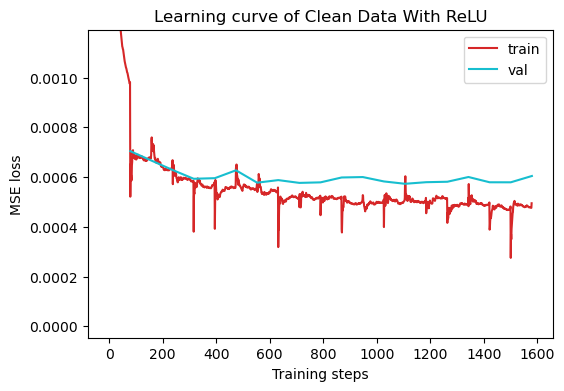

In [55]:
plot_learning_curve(relu_loss_record_clean, title="Clean Data With ReLU")

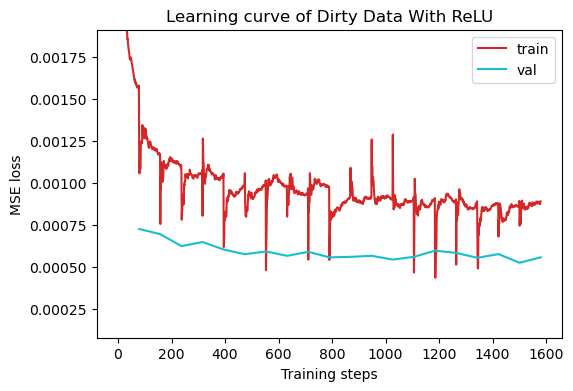

In [56]:
plot_learning_curve(relu_loss_record_dirty, title="Dirty Data With ReLU")

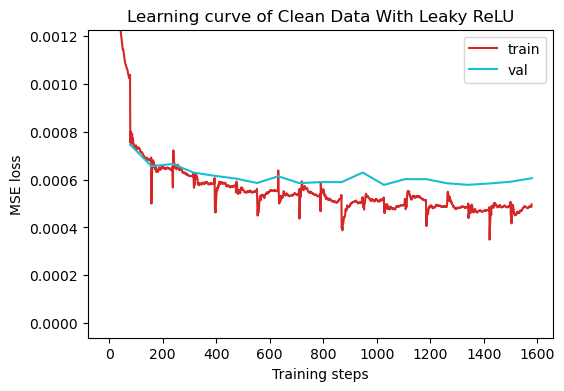

In [57]:
plot_learning_curve(lrelu_loss_record_clean, title="Clean Data With Leaky ReLU")

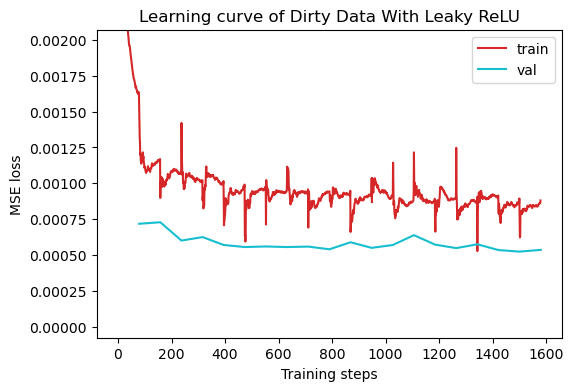

In [58]:
plot_learning_curve(lrelu_loss_record_dirty, title="Dirty Data With Leaky ReLU")

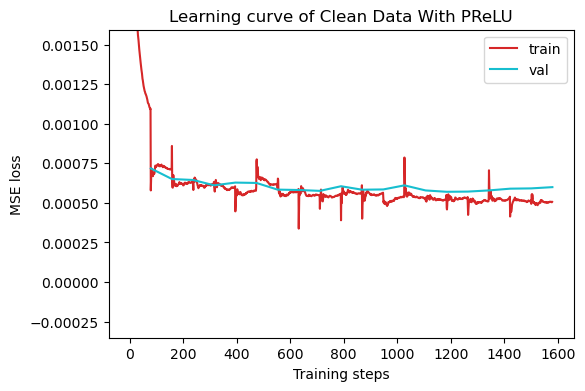

In [59]:
plot_learning_curve(prelu_loss_record_clean, title="Clean Data With PReLU")

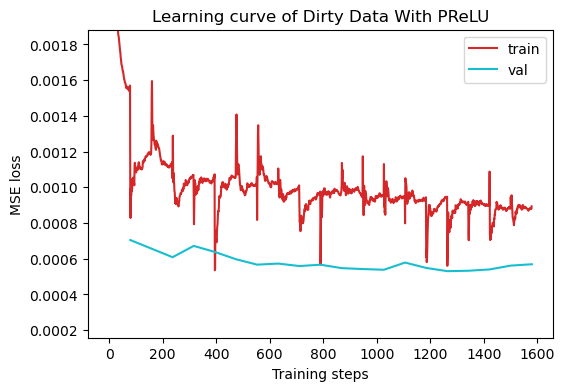

In [60]:
plot_learning_curve(prelu_loss_record_dirty, title="Dirty Data With PReLU")

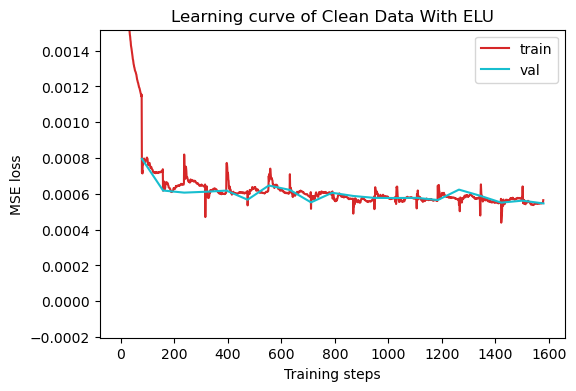

In [61]:
plot_learning_curve(elu_loss_record_clean, title="Clean Data With ELU")

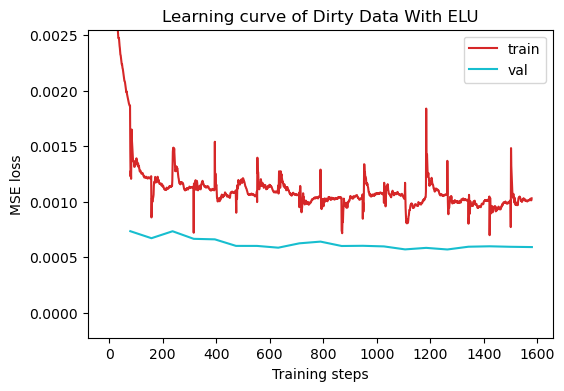

In [62]:
plot_learning_curve(elu_loss_record_dirty, title="Dirty Data With ELU")

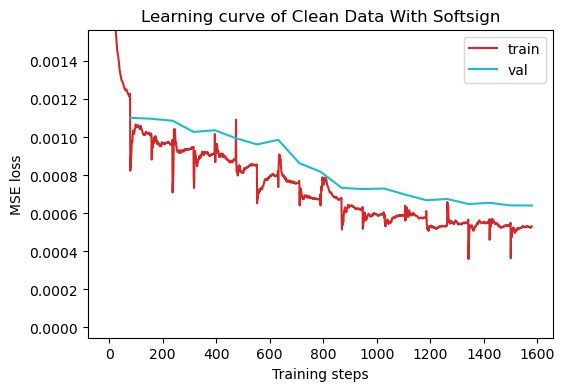

In [63]:
plot_learning_curve(softsign_loss_record_clean, title="Clean Data With Softsign")

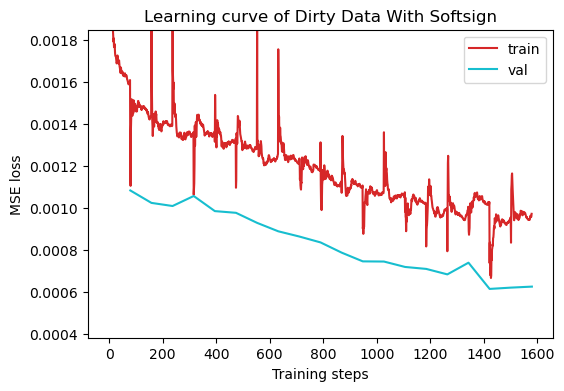

In [64]:
plot_learning_curve(softsign_loss_record_dirty, title="Dirty Data With Softsign")

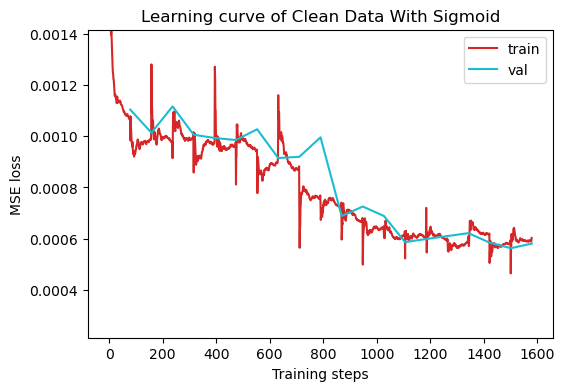

In [65]:
plot_learning_curve(sigmoid_loss_record_clean, title="Clean Data With Sigmoid")

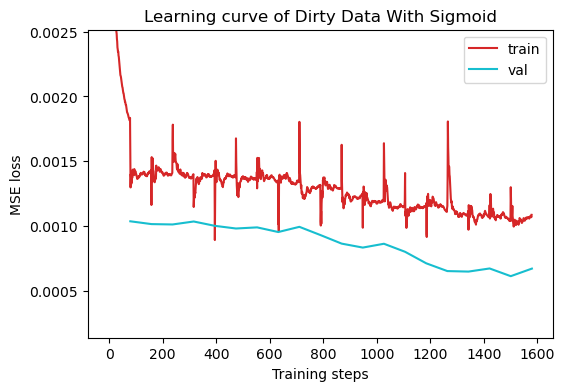

In [66]:
plot_learning_curve(sigmoid_loss_record_dirty, title="Dirty Data With Sigmoid")

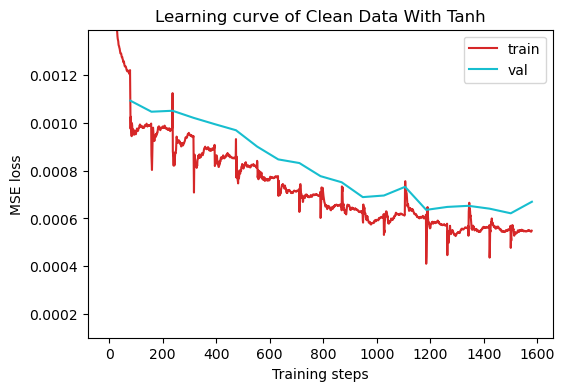

In [67]:
plot_learning_curve(tanh_loss_record_clean, title="Clean Data With Tanh")

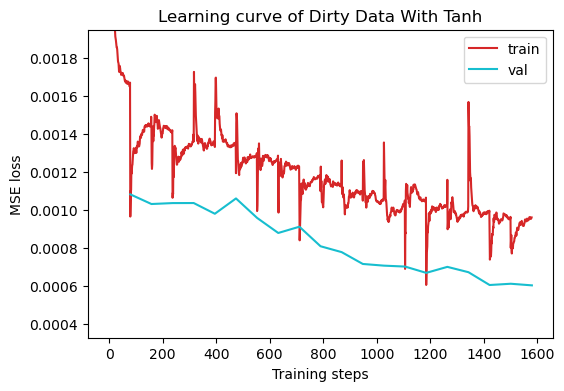

In [68]:
plot_learning_curve(tanh_loss_record_dirty, title="Dirty Data With Tanh")

# Comparing the Models

In [69]:
def plot_vals(dirty, clean, title='', num_std_devs=3):
    plt.plot(range(len(dirty)), dirty, label='dirty')
    plt.plot(range(len(clean)), clean, label='clean')
    # plt.plot(range(len(dirty)), dirty, c='tab:cyan', label='dirty')
    # plt.plot(range(len(clean)), clean, c='tab:red', label='clean')
    y_lim_low = min(np.mean(clean) - num_std_devs * np.std(clean), 
                    np.mean(dirty) - num_std_devs * np.std(dirty))
    y_lim_high = max(np.mean(clean) + num_std_devs * np.std(clean), 
                    np.mean(dirty) + num_std_devs * np.std(dirty))
    plt.ylim(y_lim_low, y_lim_high)
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.title('Val Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

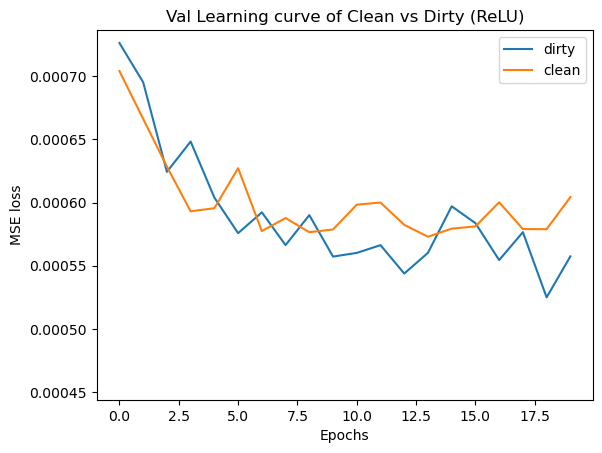

In [70]:
plot_vals(relu_loss_record_dirty['val'], relu_loss_record_clean['val'], title="Clean vs Dirty (ReLU)")

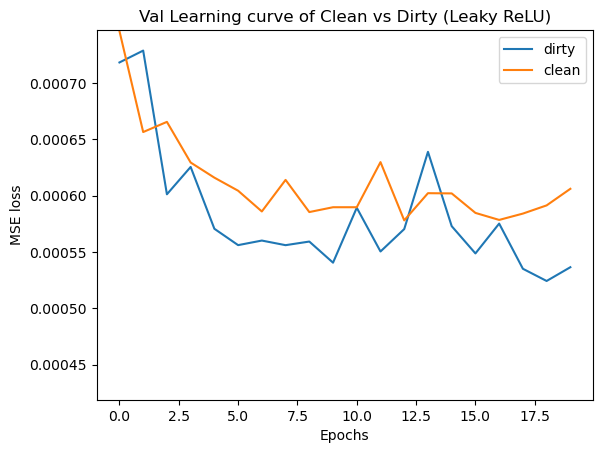

In [71]:
plot_vals(lrelu_loss_record_dirty['val'], lrelu_loss_record_clean['val'], title="Clean vs Dirty (Leaky ReLU)")

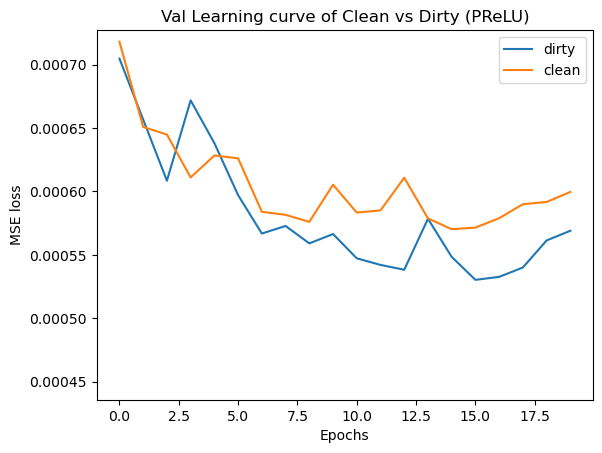

In [72]:
plot_vals(prelu_loss_record_dirty['val'], prelu_loss_record_clean['val'], title="Clean vs Dirty (PReLU)")

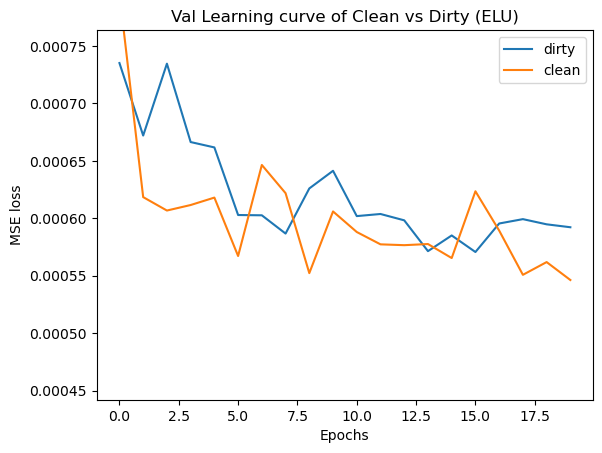

In [73]:
plot_vals(elu_loss_record_dirty['val'], elu_loss_record_clean['val'], title="Clean vs Dirty (ELU)")

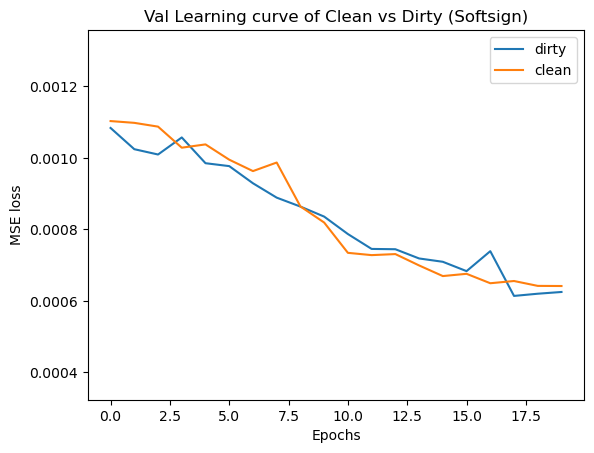

In [74]:
plot_vals(softsign_loss_record_dirty['val'], softsign_loss_record_clean['val'], title="Clean vs Dirty (Softsign)")

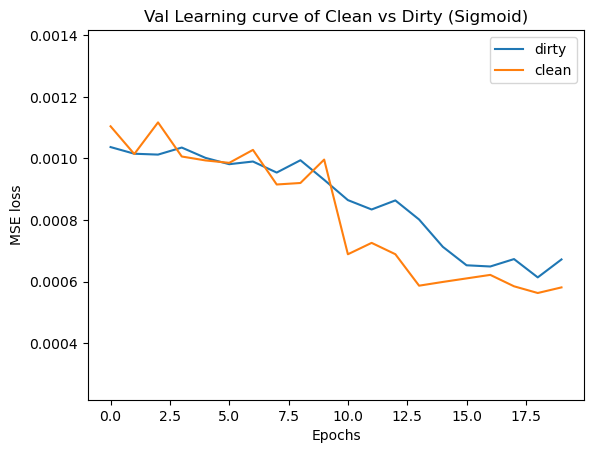

In [75]:
plot_vals(sigmoid_loss_record_dirty['val'], sigmoid_loss_record_clean['val'], title="Clean vs Dirty (Sigmoid)")

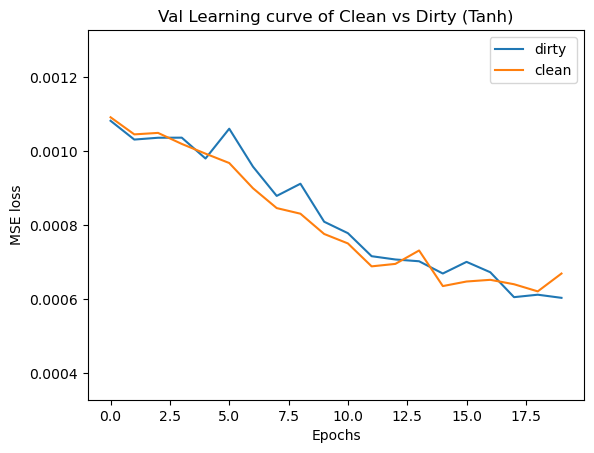

In [76]:
plot_vals(tanh_loss_record_dirty['val'], tanh_loss_record_clean['val'], title="Clean vs Dirty (Tanh)")

### Plotting Differential

In [77]:
def plot_diff(diffs, labels, title='', num_std_devs=5):
    mins = []
    maxs = []
    for i in range(len(diffs)):
        plt.plot(range(len(diffs[i])), diffs[i], label=labels[i])
        mins.append(np.mean(diffs[i]) - num_std_devs * np.std(diffs[i]))
        maxs.append(np.mean(diffs[i]) + num_std_devs * np.std(diffs[i]))
    plt.ylim(min(mins), max(maxs))
    plt.xlabel('Training steps')
    plt.ylabel('Clean MSE Loss - Dirty MSE Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [78]:
def list_diff(list1, list2):
    answer = []
    for i in range(len(list1)):
        answer.append(list1[i] - list2[i])
    return answer

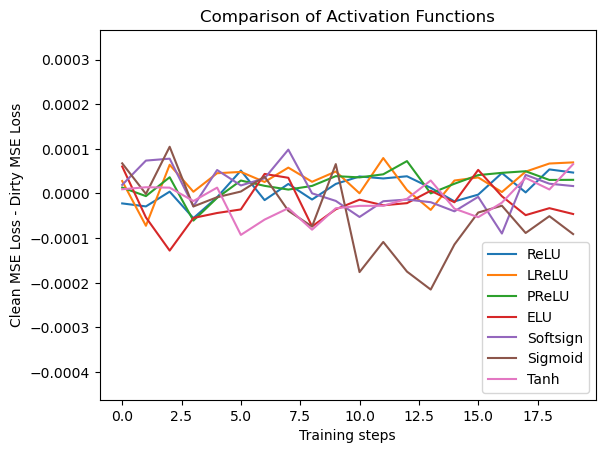

In [79]:
DIFF_relu_lrd = list_diff( relu_loss_record_clean['val'], relu_loss_record_dirty['val'])
DIFF_lrelu_lrd = list_diff(lrelu_loss_record_clean['val'], lrelu_loss_record_dirty['val'])
DIFF_prelu_lrd = list_diff(prelu_loss_record_clean['val'], prelu_loss_record_dirty['val'])
DIFF_elu_lrd = list_diff(elu_loss_record_clean['val'], elu_loss_record_dirty['val'])
DIFF_softsign_lrd = list_diff(softsign_loss_record_clean['val'], softsign_loss_record_dirty['val'])
DIFF_sigmoid_lrd = list_diff(sigmoid_loss_record_clean['val'], sigmoid_loss_record_dirty['val'])
DIFF_tanh_lrd = list_diff(tanh_loss_record_clean['val'], tanh_loss_record_dirty['val'])

plot_diff(
    diffs=[DIFF_relu_lrd, DIFF_lrelu_lrd, DIFF_prelu_lrd, DIFF_elu_lrd, DIFF_softsign_lrd, DIFF_sigmoid_lrd, DIFF_tanh_lrd], 
    labels=['ReLU', 'LReLU', 'PReLU', 'ELU', 'Softsign', 'Sigmoid', 'Tanh'], 
    title='Comparison of Activation Functions'
)